In this notebook, we iterate through each language in the MasakhaneNER2 dataset to determine the optimal value for the 'maximum number of tokens' parameter per language.

In [9]:
import sys
import os
import yaml
from transformers import AutoTokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt

# Import text preprocessing functions
preprocess_module_path = os.path.abspath('../src/data')
if preprocess_module_path not in sys.path:
    sys.path.append(preprocess_module_path)

from preprocess import align_labels_for_many_records

In [10]:
# Reading config file
config = yaml.safe_load(open("../settings/config.yml"))

In [11]:
# Loading tokenizer
tokenizer = AutoTokenizer.from_pretrained(config['model_name'])

Loop through all languages in the dataset, tokenize all text, calculate number of tokens per sentence and select maximum value per language across train / test / validation splits:

In [12]:
%%capture
max_token_counts = {}  # Dict in format {short language name: max_tokens}

for lan in config['languages_list']:
    # Load & preprocess dataset
    data = load_dataset(config['dataset'], lan)
    # Tokenize text 
    data = data.map(align_labels_for_many_records, batched=True, 
                    fn_kwargs={'tokenizer': tokenizer})
    # Get number of tokens in each record per train / test / validation split
    train_lengths = [len(record['input_ids']) for record in data['train']]
    test_lengths = [len(record['input_ids']) for record in data['test']]
    validation_lengths = [len(record['input_ids']) for record in data['validation']]

    # Save max number of records per train / test / validation
    max_token_counts[lan] = max(train_lengths + test_lengths + validation_lengths)

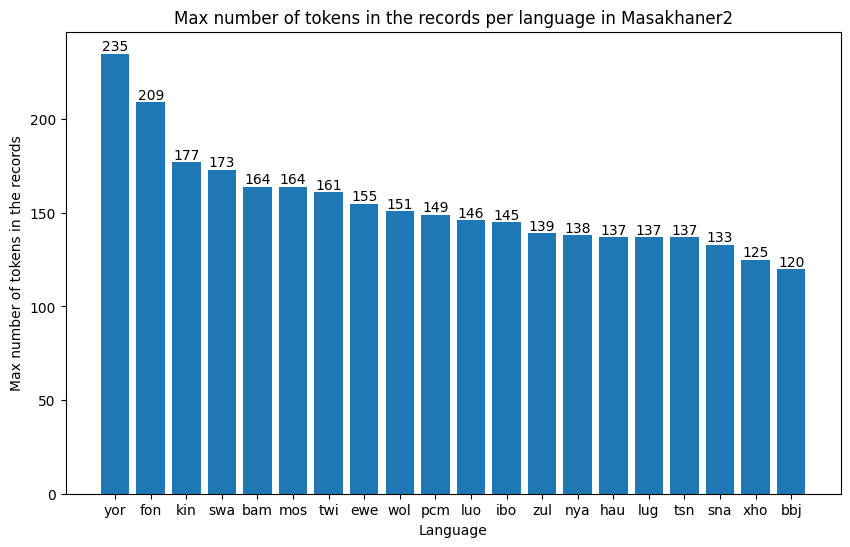

In [13]:
# Sort the token counts
top_items = dict(sorted(max_token_counts.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 6))
bars = plt.bar(top_items.keys(), top_items.values())
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')
plt.xlabel('Language')
plt.ylabel('Max number of tokens in the records')
plt.title('Max number of tokens in the records per language in Masakhaner2')
plt.show()